# Amazon Fine Food Reviews Analysis

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

Number of reviews: 568,454
Number of users: 256,059
Number of products: 74,258
Timespan: Oct 1999 - Oct 2012
Number of Attributes/Columns in data: 10

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review

Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).



### 1 Importing all necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3 
import nltk
import string
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from gensim.models import Word2Vec
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import warnings
from sklearn.manifold import TSNE
from sklearn.cross_validation import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
warnings.filterwarnings("ignore")


C:\Users\javadlam\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
C:\Users\javadlam\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### 2 Loading the data

In [2]:

#connecting to database
con = sqlite3.connect('database.sqlite')
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
filtered_data['Score'] = actualScore.map(partition)


filtered_data.shape
#filtered_data.head()

(525814, 10)

### 3 Data Cleaning

In [3]:
#sorting the data according to productId
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)

#Removing entries where helfulnessNumerator>HelpfulnessDenominator
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

final.shape
final['Score'].value_counts()



positive    307061
negative     57110
Name: Score, dtype: int64

### 4 Text Preprocessing

In [4]:
nltk.download('stopwords')
stop = set(stopwords.words('english'))
sno = nltk.stem.SnowballStemmer('english')

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1
    
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final['CleanedText']=final['CleanedText'].str.decode("utf-8")
final.shape

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\javadlam\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


(364171, 11)

In [5]:
# store final table into an SQlLite table for future
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

In [6]:
import sqlite3
con = sqlite3.connect("final.sqlite")
cleaned_data = pd.read_sql_query("select * from Reviews", con)
cleaned_data.shape
#cleaned_data.head()

(364171, 12)

In [7]:
#Sampling 250k points

final_data = cleaned_data.sample(n=250000)
final_data.shape
final_data['Score'].value_counts()

positive    210719
negative     39281
Name: Score, dtype: int64

In [30]:
# sorting the data based on time

final_data['Time'] = pd.to_datetime(final_data['Time']).sort_values()
final_data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
164883,266847,289256,B001E52WNS,A32WJDZT9QTKQ6,"Tanya Gutierrez ""Coffee Addict""",4,4,positive,1970-01-01 00:00:01.256428800,Great coffee mix,I was the kind of person that had to have my S...,kind person starbuck morn tri cafe vienna trul...
58053,104984,113970,B000EYRHL2,A1XP6TWOP1L4JN,"Kimberly ""Katy's Mom""",2,2,positive,1970-01-01 00:00:01.179446400,The Best Dried Fruit,This is the best dried fruit I've had. There ...,best dri fruit ive big whole berri great tast ...
61396,232380,252069,B000F6SNQM,A20CKV0E0GP4V1,"Larry G. Monroe ""Word Study""",0,0,positive,1970-01-01 00:00:01.242000000,Life is good w/Good Earth,"The Lemon Grass, and a hint of Ment, is just t...",lemon grass hint ment right touch make greates...
323153,74612,81168,B004TDU0RW,A3UGJF5DSOGHV3,M. Lim,0,0,positive,1970-01-01 00:00:01.333238400,So delicious and so wholesome,For those who does not like the bones in sardi...,like bone sardin kipper good altern one tomato...
66641,403565,436377,B000FFLTDM,A3OKGKMZ1W8A7Y,Kelly Mullins,2,2,positive,1970-01-01 00:00:01.286841600,Yummy!,"I love this soup! I keep it in my trunk, in my...",love soup keep trunk desk work cabinet home an...


#### Function to find optimal alpha for different vectorisation techniques

In [31]:
def find_optimal_alpha(X_train,Y_train):
   
    alphaRange = [0.00001, 0.0001, 0.001, 0.01, 1, 10, 100]
    cv_scores = []
    mnb = MultinomialNB()   
    for a in alphaRange:
        mnb = MultinomialNB(alpha = a)
        scores = cross_val_score(mnb, X_train, Y_train, cv=10, scoring='accuracy')
        cv_scores.append(scores.mean())
    
    MSE = [1 - x for x in cv_scores]
    optimal_alpha = alphaRange[MSE.index(min(MSE))]  # determining best alpha
        
    print('\nBest alpha is %f.' % optimal_alpha)
    plt.plot(alphaRange, MSE, marker = '*') 

    #for xy in zip(alpha_values, np.round(MSE,3)):
    #plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
    plt.title("Misclassification Error vs alpha")
    plt.xlabel('value of alpha')
    plt.ylabel('Misclassification Error')
    plt.show()
    
    return optimal_alpha

#### Function to find the top 25 features

In [32]:
def find_imp_features(vectorizer):
    
    class_labels = mnb_optimal.classes_
    feature_names =vectorizer.get_feature_names()
    top_class_negative = sorted(zip(mnb_optimal.feature_count_[0], feature_names),reverse=True)[:25]
    top_class_positive = sorted(zip(mnb_optimal.feature_count_[1], feature_names),reverse=True)[:25]
    print("Top 25 features in positive reviews\n")
    for coef, feat in top_class_positive:
        print(class_labels[1], coef, feat) 
    print("-------------------------------------------------------------------------")
    print("Top 25 features in negative reviews\n")
    for coef, feat in top_class_negative:
        print(class_labels[0], coef, feat)


### 5 BOW

In [33]:
# Splitting the data into train and test
X = final_data['CleanedText']
Y = final_data['Score']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 0)
print(X_train.shape,X_test.shape)
#print(X_train)
type(X_train)

(175000,) (75000,)


pandas.core.series.Series

In [34]:
# converting text to vector using Bag of Words
unigram_bow = CountVectorizer()

#Train vectorizer
X_train = unigram_bow.fit_transform(X_train)
print(X_train.shape)

#Test vectorizer
X_test = unigram_bow.transform(X_test)
print(X_test.shape)

type(X_train)

(175000, 50171)
(75000, 50171)


scipy.sparse.csr.csr_matrix


Best alpha is 1.000000.


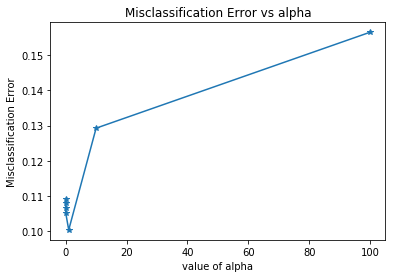

In [35]:
# finding optimal alpha
optimal_alpha_bow = find_optimal_alpha(X_train, Y_train)

In [36]:
# Learning the model with optimal alpha
mnb_optimal = MultinomialNB(alpha = optimal_alpha_bow)
# fitting the model
mnb_optimal.fit(X_train,Y_train)

#Predicting the output
pred = mnb_optimal.predict(X_test)

train_acc_bow = mnb_optimal.score(X_train, Y_train)
print("Train accuracy", train_acc_bow)

acc_bow = accuracy_score(Y_test, pred) * 100
print('\nTest accuracy for alpha = %d is %f%%' % (optimal_alpha_bow, acc_bow))

Train accuracy 0.9118457142857143

Test accuracy for alpha = 1 is 90.185333%


In [37]:
# classification report
print(classification_report(Y_test, pred))

             precision    recall  f1-score   support

   negative       0.70      0.66      0.68     11813
   positive       0.94      0.95      0.94     63187

avg / total       0.90      0.90      0.90     75000



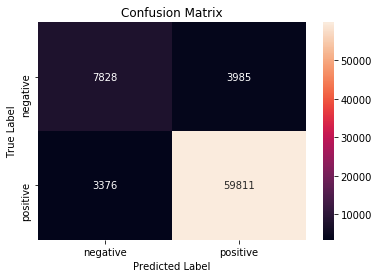

In [38]:
# Confusion matrix
import seaborn as sns
class_label = ["negative", "positive"]
cm = confusion_matrix(Y_test, pred)
cm_array = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(cm_array, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [39]:
# Top 25 features
find_imp_features(unigram_bow)

Top 25 features in positive reviews

positive 66934.0 like
positive 62434.0 tast
positive 54152.0 good
positive 52897.0 flavor
positive 51595.0 love
positive 50233.0 great
positive 49609.0 use
positive 46759.0 one
positive 43424.0 product
positive 41601.0 tri
positive 40649.0 tea
positive 38192.0 coffe
positive 36264.0 make
positive 34704.0 get
positive 30942.0 food
positive 26902.0 would
positive 26721.0 time
positive 25995.0 buy
positive 25235.0 realli
positive 24893.0 eat
positive 23771.0 amazon
positive 23562.0 price
positive 23213.0 also
positive 23022.0 much
positive 23016.0 find
-------------------------------------------------------------------------
Top 25 features in negative reviews

negative 16555.0 tast
negative 15372.0 like
negative 13449.0 product
negative 9975.0 one
negative 9381.0 flavor
negative 8621.0 would
negative 8525.0 tri
negative 7263.0 use
negative 7174.0 good
negative 7026.0 coffe
negative 6616.0 get
negative 6558.0 buy
negative 6204.0 food
negative 6105.0 or

#### Observations

* Test Accuracy on unseen test data is 90% with optimal apha = 1
* Precision, recall and f1 score are the best metrics when we have an imbalanced dataset which are high in our case.
* So from the confusion matrix we can see that out of total negative points (11813) the model predicted 11204 and out of total positive points (63187) the model predicted 63796 
* False positive rate (FPR) is 0.062 that means 6% negative labels are incorrectly classified as positive.
                    

### 6 TF-IDF

In [40]:
#Spltting the data into train and test
X = final_data['CleanedText']
Y = final_data['Score']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 0)
print(X_train.shape,X_test.shape)
#print(X_train)
type(X_train)

(175000,) (75000,)


pandas.core.series.Series

In [41]:
#Converting text to vector using TF-IDF vectorizer
tfidf = TfidfVectorizer(ngram_range=(1,2))

#Train vectorizer
X_train = tfidf.fit_transform(X_train)
X_train.shape

(175000, 1834546)

In [42]:
#Test Vectorizer
X_test = tfidf.transform(X_test)
X_test.shape

(75000, 1834546)


Best alpha is 0.001000.


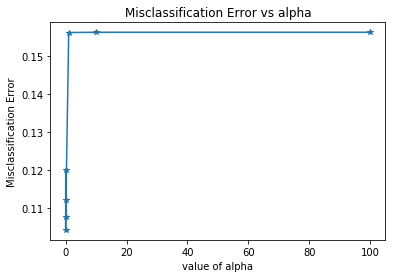

In [43]:
# find optimal alpha
optimal_alpha_tfidf = find_optimal_alpha(X_train, Y_train)

In [55]:
# Learning the model with optimal alpha
mnb_optimal = MultinomialNB(alpha = optimal_alpha_tfidf)
#fitting the model
mnb_optimal.fit(X_train,Y_train)
#predicting the output
pred = mnb_optimal.predict(X_test)

train_acc_tfidf = mnb_optimal.score(X_train, Y_train)
print("Train accuracy", train_acc_tfidf)

acc_tfidf = accuracy_score(Y_test, pred) * 100
print('\nTest accuracy for alpha = %f is %f%%' % (optimal_alpha_tfidf, acc_tfidf))

Train accuracy 0.9982971428571429

Test accuracy for alpha = 0.001000 is 88.690667%


In [45]:
# classification report
print(classification_report(Y_test, pred))

             precision    recall  f1-score   support

   negative       0.87      0.33      0.48     11813
   positive       0.89      0.99      0.94     63187

avg / total       0.88      0.89      0.86     75000



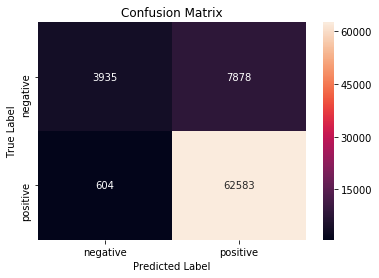

In [46]:
# confusion matrix

class_label = ["negative", "positive"]
cm = confusion_matrix(Y_test, pred)
cm_array = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(cm_array, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [47]:
#Top 25 features
find_imp_features(tfidf)

Top 25 features in positive reviews

positive 2085.38965601066 great
positive 2070.4916283091884 love
positive 1986.1658179677586 tast
positive 1953.0182841309663 like
positive 1949.784882679374 good
positive 1892.2149314359558 tea
positive 1842.826359974291 flavor
positive 1825.231603591449 coffe
positive 1654.2586806274328 use
positive 1641.3513368422962 product
positive 1507.2381394994302 one
positive 1415.2472177531295 tri
positive 1311.4323195349416 make
positive 1233.9895515549526 get
positive 1169.683444062326 food
positive 1158.9004636147881 price
positive 1152.445397503241 best
positive 1149.2320397181434 buy
positive 1079.758385837902 time
positive 1075.1334115569412 order
positive 1069.9978122399814 realli
positive 1065.6067666576332 find
positive 1054.0581097431527 amazon
positive 1029.1814944207078 eat
positive 1014.744925588432 dog
-------------------------------------------------------------------------
Top 25 features in negative reviews

negative 510.6822066975504 tast

#### Observations

* Test Accuracy on unseen test data is 89% with optimal apha = 0.001
* Precision, recall and f1 score are the best metrics when we have an imbalanced dataset.
* From the confusion matrix we can say that out of total negative points (11813) the model predicted 4539 and out of total positive points (63187) the model predicted 70461
* From above point we can say only 45% of negative points are predicted correctly.
* False positive rate is 11% in tf-idf which means 11% points are miscalssified as positive points when they are actually negative.
                    

In [56]:
df = pd.DataFrame({'Model': ['Bow', "TFIDF"], 'Hyper Parameter(alpha)': [optimal_alpha_bow, optimal_alpha_tfidf], 'Accuracy': [acc_bow, acc_tfidf]}, columns = ["Model", "Hyper Parameter(alpha)", "Accuracy"])
df

,Model,Hyper Parameter(alpha),Accuracy
0,Bow,1.000,90.185333
1,TFIDF,0.001,88.690667


### 9 Conclusion

* When compared to BOW and tf-idf vectorisation techinques BOW performs well with accuracy of 90 and 88 respectively.
* Also the FPR of tfidf is little high when compared to BOW.
* Naive Bayes doesn't perform well on Word2Vec features as they are dependent, while Naive Bayes classifier assumes that the       presence of a particular feature in a class is unrelated to the presence of any other feature.
* As train accuracy and test accuracy of BOW and TF-IDF are approximately same, so we can say our model performs well on unseen   data.
* Naive Bayes is faster in its traning time than other algorithms like KNN.